In [2]:
import graphs
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import jax
import time
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from scipy.special import softmax
import optax
from model import *
ndevices = jax.local_device_count()
print(jax.devices())

device = 0
jax.config.update("jax_default_device", jax.devices()[device])
# key = random.PRNGKey(device)
seed = device
np.random.seed(seed)

%load_ext autoreload
%autoreload 2

[cuda(id=0)]


In [3]:
print(jax.devices())

[cuda(id=0)]


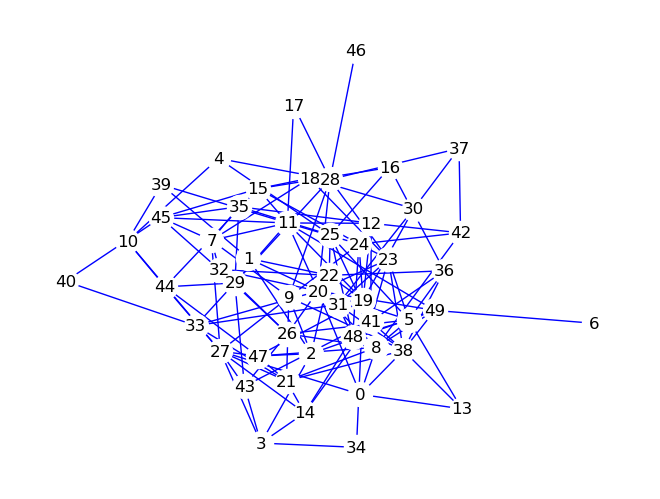

In [4]:
graph_type = "bernoulli"
N = 50
p = 0.1

if graph_type == "bernoulli":
    G = graphs.create_bernoulli_graph(num_nodes = N, p = p)
elif graph_type == "spoke":
    G = graphs.create_spoke_graph(num_nodes = N)
elif graph_type == "ring":
    G = graphs.create_ring_graph(num_nodes = N)
else: 
    print("Graph type not recognized")

G, best_loss = graphs.compute_policy_degen(G)

#plot G using networkx  
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edge_color='b')
#nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=False)

plt.show()


In [5]:
G, best_loss = graphs.compute_policy_degen(G)
num_nodes = G.number_of_nodes()
tprobs = np.zeros((num_nodes,num_nodes))
for i in range(num_nodes):
    tprobs[i] = G.nodes[i]['tprobs']

Ne = 128
niter = 15000
We = np.random.randn(num_nodes,Ne)/np.sqrt(Ne)
V = np.random.randn(Ne,Ne)/np.sqrt(Ne)
Wu = np.random.randn(num_nodes,Ne)/np.sqrt(Ne)

params = [We,V,Wu]

test,_ = generate_batch(G,1000)

optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state, batch, labels):
    loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

bias1s = []
bias2s = []
losses = []

for i in range(niter):
    triplets,_ = generate_batch(G,128)
    params, opt_state, loss_value = step(params, opt_state, triplets[:,:2], triplets[:,2])
    
    if i%200==0:
        index, bias1,bias2,ps = compute_bias(G,params)
        
        loss_value = loss(params,test[:,:2],test[:,2])

        bias1s.append(bias1)
        bias2s.append(bias2)
        losses.append(loss_value)

        print("Niter %05d"%i,"Loss %.2f"%loss_value,"Bias1  %.3f"%np.mean(bias1),"Bias2  %.3f"%np.mean(bias2), \
                r"$\Delta$Bias1  %.3f"%np.std(bias1), "BestLoss %.3f"%best_loss)


2024-02-16 13:40:41.877457: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:442] There was an error before creating cudnn handle (35): cudaErrorInsufficientDriver : CUDA driver version is insufficient for CUDA runtime version
2024-02-16 13:40:41.877745: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:442] There was an error before creating cudnn handle (35): cudaErrorInsufficientDriver : CUDA driver version is insufficient for CUDA runtime version


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
start_next = params[2]@params[0].T
goal_next = params[2]@(params[1].T@params[0].T)
graph_type = "bernoulli"

plt.close("all")
plt.imshow(start_next,aspect="auto", origin="lower")
plt.colorbar()
plt.title(r"$\psi_n^T \phi_s$")
plt.ylabel(r"$n$")
plt.xlabel(r"$s$")
plt.tight_layout()
plt.savefig("figs/start_next_N%d_p%.2f_Ne%d_G" + graph_type + ".png")
plt.show()

plt.close("all")
plt.imshow(nx.adjacency_matrix(G).toarray(),aspect="auto", or   igin="lower")
plt.colorbar()
plt.title(r"$A$")
plt.ylabel(r"$n$")
plt.xlabel(r"$s$")
plt.tight_layout()
plt.savefig("figs/adja_N%d_p%.2f_Ne%d_G" + graph_type + ".png")
plt.show()


plt.close("all")
plt.imshow(goal_next,aspect="auto", origin="lower")
plt.colorbar()
plt.title(r"$\psi_n^T V \phi_g$")
plt.ylabel(r"$n$")
plt.xlabel(r"$g$")
plt.tight_layout()
plt.savefig("figs/goal_next_N%d_p%.2f_Ne%d_G" + graph_type + ".png")
plt.show()

In [ ]:
neighbors = []
nneighbors = []
for next in range(num_nodes):
    filt = np.array([n for n in G.neighbors(next)])
    arr = np.zeros(num_nodes, dtype = bool)
    arr[filt] = True
    neighbors += list(start_next[next,filt])
    nneighbors += list(start_next[next,~filt])    

plt.close("all")
plt.hist(neighbors, bins = 50, alpha = 0.5, label = "neighbors")
plt.hist(nneighbors, bins = 50, alpha = 0.5, label = "non-neighbors")
plt.legend()
plt.ylabel("Count")
plt.xlabel(r"$\psi_n^T \phi_s$")
plt.show()

neighbors_mean = np.mean(neighbors)
nneighbors_mean = np.mean(nneighbors)

print(neighbors_mean, nneighbors_mean)


In [ ]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(5,5))
xs = []
ys = []
for next in range(num_nodes):
    distances = nx.shortest_path_length(G,source=next)
    dists = np.array([distances[i] for i in range(num_nodes)])
    xs.append(list(dists))
    ys.append(list(goal_next[next,:]))

xs = np.array(xs)
ys = np.array(ys)
ys_means = []
axis.plot(xs,ys,"ko",alpha=0.5)
for i in range(np.max(xs)+1):
    filt = xs == i
    axis.plot(i,np.mean(ys[filt]),"rs")
    ys_means += [np.mean(ys[filt])]

ps = np.polyfit(np.arange(np.max(xs)+1),np.array(ys_means),1)
r2 = r2_score(np.array(ys_means),ps[0]*np.arange(np.max(xs)+1)+ps[1])
print(r2)
axis.plot(np.arange(np.max(xs)+1), ps[0]*np.arange(np.max(xs)+1)+ps[1],"r--")
fig.tight_layout()
axis.set_xlabel("Distance")
axis.set_ylabel(r"$\psi_n^T V \phi_g$")
axis.set_title(r"$R^2$ = %.3f"%r2)
plt.show()


In [ ]:
np.arange(np.max(xs)+1)

In [ ]:
id = 15
distances = nx.shortest_path_length(G, source=id)
dists = np.array([distances[i] for i in range(num_nodes)])

plt.close("all")
plt.plot(goal_next[:,id])
#plt.plot(-2.5*dists + 17)
plt.ylabel(r"$\psi_n^T V \phi_g$")
plt.xlabel(r"Node index")
plt.tight_layout()
plt.savefig("figs/goal_next_15.png")
plt.show()

In [ ]:
print(goal_next[1,15], goal_next[30,15])
print(start_next[1,0], start_next[30,0])

In [ ]:
goal_next_bias = np.zeros(int(num_nodes/2))
start_next_bias = np.zeros(int(num_nodes/2))
for goal in range(int(num_nodes/2)):
    start = (goal + int(num_nodes/4))%int(num_nodes/2)
    next1 = (start + 1)%int(num_nodes/2)
    next2 = (start - 1)%int(num_nodes/2)
    goal_next_bias[goal] = goal_next[next2,goal] - goal_next[next1,goal]
    start_next_bias[goal] = start_next[next2,start] - start_next[next1,start]
    # print("goal: %d"%goal)
    # print(goal_next[next1,goal], goal_next[next2,goal])
    # print(start_next[next1,start], start_next[next2,start])
    # print(start_next[next1,start] + goal_next[next1,goal], start_next[next2,start] + goal_next[next2,goal])

plt.close("all")
plt.plot(goal_next_bias,'o', label = "next_to_goal bias")
plt.plot(start_next_bias,'o', label = "start_to_next bias")
plt.plot(start_next_bias + goal_next_bias,'x', ms = 5, mew = 2, label = "total bias")
mean_goal_next_bias = np.mean(goal_next_bias)
mean_start_next_bias = np.mean(start_next_bias)
plt.plot([0,num_nodes/2],[mean_goal_next_bias,mean_goal_next_bias],'C0--')
plt.plot([0,num_nodes/2],[mean_start_next_bias,mean_start_next_bias], 'C1--')
plt.ylim(-2,2)
plt.legend(loc = 3)
plt.tight_layout()
plt.savefig("figs/bias_decomposition.png")
plt.show()


In [ ]:
params[0].shape

In [ ]:
np.array([n for n in G.neighbors(0)])